In [2]:

! pip install langchain langchain-groq langchain-community langgraph python-dotenv faiss-cpu pypdf

   ---------------------------------------- 0.0/18.9 MB ? eta -:--:--
   -- ------------------------------------- 1.3/18.9 MB 7.3 MB/s eta 0:00:03
   --- ------------------------------------ 1.8/18.9 MB 8.4 MB/s eta 0:00:03
   ----------- ---------------------------- 5.2/18.9 MB 8.6 MB/s eta 0:00:02
   ---------------- ----------------------- 7.6/18.9 MB 9.3 MB/s eta 0:00:02
   --------------------- ------------------ 10.0/18.9 MB 9.6 MB/s eta 0:00:01
   -------------------------- ------------- 12.3/18.9 MB 10.0 MB/s eta 0:00:01
   ------------------------------- -------- 14.7/18.9 MB 10.2 MB/s eta 0:00:01
   ------------------------------------ --- 17.0/18.9 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 18.9/18.9 MB 10.3 MB/s  0:00:01

   ---------------------------------------- 0/3 [pypdf]
   ---------------------------------------- 0/3 [pypdf]
   ---------------------------------------- 0/3 [pypdf]
   ---------------------------------------- 0/3 [pypdf]
   ---


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\indroneel\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [5]:
! pip install sentence-transformers
! pip install langchain-huggingface

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached torch-2.9.1-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl (2.7 MB)
Using cached fsspec-2025.12.0-py3-none-any.whl (201 kB)
Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl (341 kB)
Using


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\indroneel\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\indroneel\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [9]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
import os

In [7]:
load_dotenv()

True

In [10]:
# Initialize LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",  # or llama3-70b-8192, mixtral-8x7b-32768
    temperature=0.7,
    groq_api_key=os.getenv("GROQ_API_KEY"),
)

In [12]:
loader = PyPDFLoader("ChatBot\intro-to-ml.pdf")
docs = loader.load()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\indroneel\AppData\Local\Temp\ipykernel_14380\4018464280.py:1: SyntaxWarning: invalid escape sequence '\i'
  loader = PyPDFLoader("ChatBot\intro-to-ml.pdf")


In [13]:
len(docs)

392

In [14]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [15]:
len(chunks)

973

In [16]:
# Initialize embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={'device': 'cpu'},  # Use 'cuda' for GPU
    encode_kwargs={'normalize_embeddings': True}
)

In [17]:
vector_store = FAISS.from_documents(chunks, embeddings)

In [18]:
vector_store

In [19]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [20]:

@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [21]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [22]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [23]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [24]:
tool_node = ToolNode(tools)

In [25]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

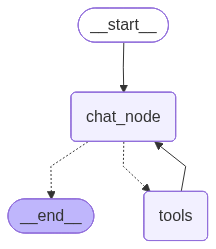

In [26]:
chatbot

In [27]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

In [28]:
print(result['messages'][-1].content)

The ideal value of K in KNN can be found by using a method such as cross-validation to evaluate the performance of the model with different values of K. The value of K that results in the best performance is then chosen. Additionally, the choice of K depends on the dataset and the problem being solved, and there is no one-size-fits-all solution. It's also important to preprocess the data and consider the distance measure used in the KNN algorithm. 

In the context of the provided pdf notes, the KNN algorithm is implemented in the KNeighborsClassifier class in the neighbors module of scikit-learn, and the number of neighbors is set using the n_neighbors parameter. The fit method is then used to train the model, and the predict method is used to make predictions. 

It's worth noting that the pdf notes do not provide a specific method for finding the ideal value of K, but rather emphasize the importance of preprocessing the data and considering the distance measure used in the KNN algorit